In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)
import random
random.seed(42)
from project1 import defs

train: pd.DataFrame = defs.load_asset_value("train")
test: pd.DataFrame = defs.load_asset_value("test")

2024-04-12 12:13:10 -0700 - dagster - DEBUG - system - Loading file from: /home/maguire/ucla/ece219/project1/project1/../data/train using PickledObjectFilesystemIOManager...
2024-04-12 12:13:10 -0700 - dagster - DEBUG - system - Loading file from: /home/maguire/ucla/ece219/project1/project1/../data/test using PickledObjectFilesystemIOManager...


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.svm import SVC
from project1.utils.TextPreprocessor import TextPreprocessor

pipe = Pipeline(
    steps=[
        ('preprocess', TextPreprocessor(n_jobs=2)),
        ('count', CountVectorizer(stop_words="english")),
        ('tfidf', TfidfTransformer()),
        ('dim_reduce', "passthrough"),
        ('classifier', "passthrough")
    ]
)

grid = [
    {
        "preprocess__type": ["lemm", "stem"],
        "count__min_df": [3, 5],
        "dim_reduce": [TruncatedSVD(), NMF()],
        "dim_reduce__n_components": [5, 30, 80],
        "classifier": [
            SVC(C=100, probability=True, kernel="linear"),
        ]
    },
    {
        "preprocess__type": ["lemm", "stem"],
        "count__min_df": [3, 5],
        "dim_reduce": [TruncatedSVD(), NMF()],
        "dim_reduce__n_components": [5, 30, 80],
        "classifier": [
            LogisticRegression(solver='saga'),
        ],
        "classifier__C": [100, 1000],
        "classifier__penalty": ["l1", "l2"]
    },
    {
        "preprocess__type": ["lemm", "stem"],
        "count__min_df": [3, 5],
        "dim_reduce": [TruncatedSVD(), NMF()],
        "dim_reduce__n_components": [5, 30, 80],
        "classifier": [
            GaussianNB(),
        ]
    }
]

# Be Warned
The following cell will take forever to complete when run. I can try to optimize it if needed but it does finish. It took my computer about 4 and a half hours. The end result is saved to a pkl file afterwards, it is recommended to load the result in from that file if it is available rather than re-run the GridSearch.

In [3]:
clf = GridSearchCV(
    pipe,
    param_grid=grid,
    scoring="accuracy",
    n_jobs=2,
    cv=5
)

clf.fit(train['full_text'], train['root_label'])

/home/maguire/ucla/ece219/project1/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/home/maguire/ucla/ece219/project1/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/home/maguire/ucla/ece219/project1/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/home/maguire/ucla/ece219/project1/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  retu

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        TextPreprocessor(n_jobs=2)),
                                       ('count',
                                        CountVectorizer(stop_words='english')),
                                       ('tfidf', TfidfTransformer()),
                                       ('dim_reduce', 'passthrough'),
                                       ('classifier', 'passthrough')]),
             n_jobs=2,
             param_grid=[{'classifier': [SVC(C=100, kernel='linear',
                                             probability=True)],
                          'count__min_df': [3, 5],
                          'dim_reduce': [TruncatedS...
                          'classifier__C': [100, 1000],
                          'classifier__penalty': ['l1', 'l2'],
                          'count__min_df': [3, 5],
                          'dim_reduce': [TruncatedSVD(), NMF()],
                          'dim_reduce__n_components': [5, 30, 80],
                          'preprocess__type': ['lemm', 'stem']},
                         {'classifier': [GaussianNB()], 'count__min_df': [3, 5],
                          'dim_reduce': [TruncatedSVD(), NMF()],
                          'dim_reduce__n_components': [5, 30, 80],
                          'preprocess__type': ['lemm', 'stem']}],
             scoring='accuracy')

In [4]:
import joblib

joblib.dump(clf, '../../data/GridSearchResults.pkl') # Saves the grid search result

['../../data/GridSearchResults.pkl']

Uncomment and use the below code to load the grid search if the results are available

In [11]:
# clf = joblib.load('../../data/GridSearchResults.pkl')

In [13]:
df = pd.DataFrame(clf.cv_results_)
sorted_df = df.sort_values('rank_test_score')
sorted_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_count__min_df,param_dim_reduce,param_dim_reduce__n_components,param_preprocess__type,param_classifier__C,param_classifier__penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
65,32.306661,0.479347,10.776995,0.140172,LogisticRegression(solver='saga'),5,TruncatedSVD(),80,stem,100,l2,{'classifier': LogisticRegression(solver='saga...,0.964029,0.965827,0.960432,0.964029,0.956835,0.962230,0.003217,1
53,31.990940,0.234888,10.865763,0.241144,LogisticRegression(solver='saga'),3,TruncatedSVD(),80,stem,100,l2,{'classifier': LogisticRegression(solver='saga...,0.958633,0.964029,0.962230,0.962230,0.958633,0.961151,0.002158,2
89,32.024744,0.226334,10.764587,0.131862,LogisticRegression(solver='saga'),5,TruncatedSVD(),80,stem,1000,l1,{'classifier': LogisticRegression(solver='saga...,0.964029,0.965827,0.958633,0.960432,0.955036,0.960791,0.003841,3
41,31.365076,0.344565,10.562984,0.189633,LogisticRegression(solver='saga'),5,TruncatedSVD(),80,stem,100,l1,{'classifier': LogisticRegression(solver='saga...,0.956835,0.962230,0.965827,0.962230,0.955036,0.960432,0.003940,4
101,31.834713,0.514357,10.553519,0.166536,LogisticRegression(solver='saga'),3,TruncatedSVD(),80,stem,1000,l2,{'classifier': LogisticRegression(solver='saga...,0.956835,0.964029,0.965827,0.960432,0.955036,0.960432,0.004101,4


In [14]:
clf.best_estimator_

Pipeline(steps=[('preprocess', TextPreprocessor(n_jobs=2, type='stem')),
                ('count', CountVectorizer(min_df=5, stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('dim_reduce', TruncatedSVD(n_components=80)),
                ('classifier', LogisticRegression(C=100, solver='saga'))])

In [16]:
print(clf.best_estimator_)

Pipeline(steps=[('preprocess', TextPreprocessor(n_jobs=2, type='stem')),
                ('count', CountVectorizer(min_df=5, stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('dim_reduce', TruncatedSVD(n_components=80)),
                ('classifier', LogisticRegression(C=100, solver='saga'))])


/home/maguire/ucla/ece219/project1/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


ROC plot: 


/home/maguire/ucla/ece219/project1/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


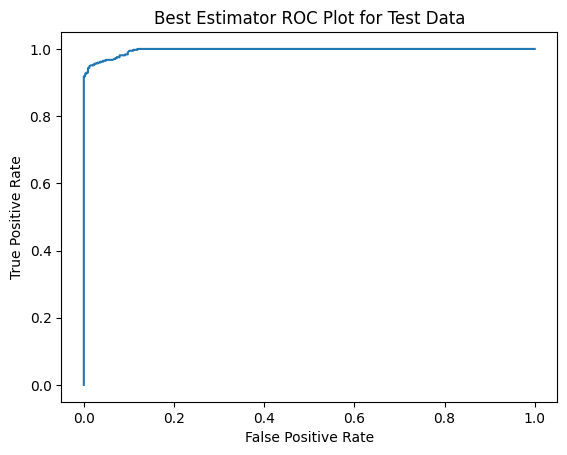

Confusion Matrix: 
[[318  10]
 [ 15 353]]
Accuracy Score: 
0.9640804597701149
Recall Score: 
0.9592391304347826
Precision Score: 
0.9724517906336089
F1 Score: 
0.9658002735978112


In [18]:
from project1.utils.MetricsAnalyzer import MetricsAnalyzer
metrics = MetricsAnalyzer(clf.best_estimator_, test['full_text'], test['root_label'], pos_label="sports")
metrics.print_all(plot_title="Best Estimator ROC Plot for Test Data")

/home/maguire/ucla/ece219/project1/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/home/maguire/ucla/ece219/project1/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/maguire/ucla/ece219/project1/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


ROC plot: 


/home/maguire/ucla/ece219/project1/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


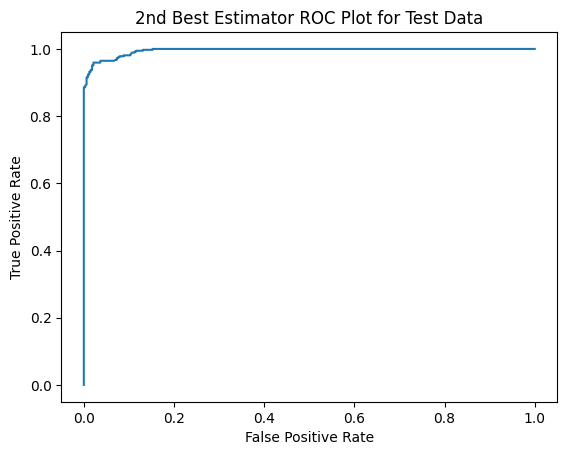

Confusion Matrix: 
[[319   9]
 [ 15 353]]
Accuracy Score: 
0.9655172413793104
Recall Score: 
0.9592391304347826
Precision Score: 
0.9751381215469613
F1 Score: 
0.9671232876712329


In [19]:
pipe_2 = Pipeline(
    steps=[
        ('preprocess', TextPreprocessor(type="stem", n_jobs=2)),
        ('count', CountVectorizer(stop_words="english", min_df=3)),
        ('tfidf', TfidfTransformer()),
        ('dim_reduce', TruncatedSVD(n_components=80)),
        ('classifier', LogisticRegression(penalty='l2', C=100, solver='saga'))
    ]
)
pipe_2.fit(train['full_text'], train['root_label'])
metrics_2 = MetricsAnalyzer(pipe_2, test['full_text'], test['root_label'], pos_label="sports")
metrics_2.print_all(plot_title="2nd Best Estimator ROC Plot for Test Data")

/home/maguire/ucla/ece219/project1/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/home/maguire/ucla/ece219/project1/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/maguire/ucla/ece219/project1/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


ROC plot: 


/home/maguire/ucla/ece219/project1/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


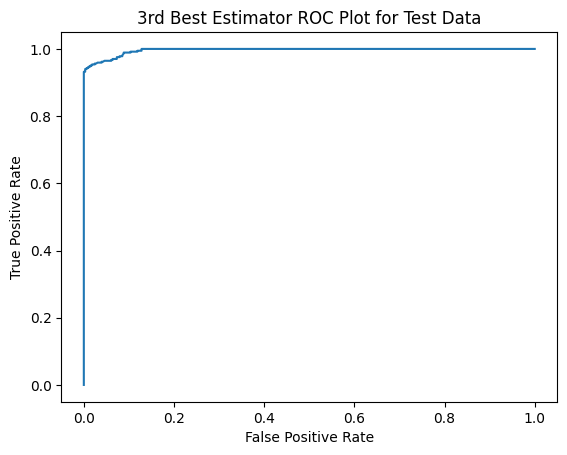

Confusion Matrix: 
[[322   6]
 [ 17 351]]
Accuracy Score: 
0.9669540229885057
Recall Score: 
0.9538043478260869
Precision Score: 
0.9831932773109243
F1 Score: 
0.9682758620689655


In [20]:
pipe_3 = Pipeline(
    steps=[
        ('preprocess', TextPreprocessor(type="stem", n_jobs=2)),
        ('count', CountVectorizer(stop_words="english", min_df=5)),
        ('tfidf', TfidfTransformer()),
        ('dim_reduce', TruncatedSVD(n_components=80)),
        ('classifier', LogisticRegression(penalty='l1', C=1000, solver='saga'))
    ]
)
pipe_3.fit(train['full_text'], train['root_label'])
metrics_3 = MetricsAnalyzer(pipe_3, test['full_text'], test['root_label'], pos_label="sports")
metrics_3.print_all(plot_title="3rd Best Estimator ROC Plot for Test Data")

/home/maguire/ucla/ece219/project1/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/home/maguire/ucla/ece219/project1/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/maguire/ucla/ece219/project1/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


ROC plot: 


/home/maguire/ucla/ece219/project1/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


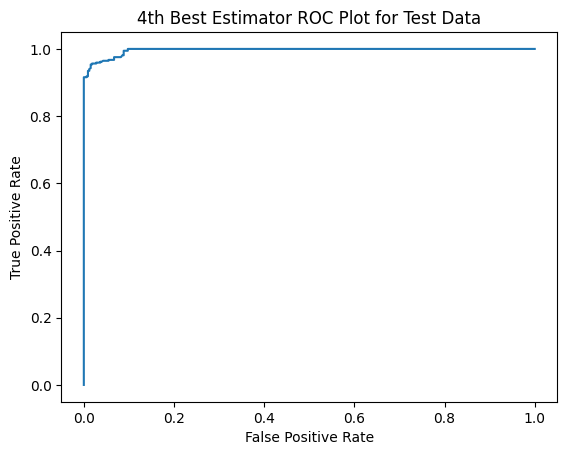

Confusion Matrix: 
[[319   9]
 [ 16 352]]
Accuracy Score: 
0.9640804597701149
Recall Score: 
0.9565217391304348
Precision Score: 
0.9750692520775623
F1 Score: 
0.9657064471879286


In [21]:
pipe_4 = Pipeline(
    steps=[
        ('preprocess', TextPreprocessor(type="stem", n_jobs=2)),
        ('count', CountVectorizer(stop_words="english", min_df=5)),
        ('tfidf', TfidfTransformer()),
        ('dim_reduce', TruncatedSVD(n_components=80)),
        ('classifier', LogisticRegression(penalty='l1', C=100, solver='saga'))
    ]
)
pipe_4.fit(train['full_text'], train['root_label'])
metrics_4 = MetricsAnalyzer(pipe_4, test['full_text'], test['root_label'], pos_label="sports")
metrics_4.print_all(plot_title="4th Best Estimator ROC Plot for Test Data")

/home/maguire/ucla/ece219/project1/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/home/maguire/ucla/ece219/project1/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/maguire/ucla/ece219/project1/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


ROC plot: 


/home/maguire/ucla/ece219/project1/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


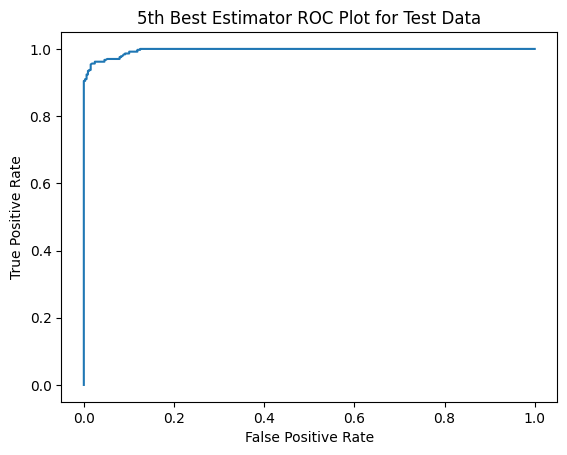

Confusion Matrix: 
[[320   8]
 [ 16 352]]
Accuracy Score: 
0.9655172413793104
Recall Score: 
0.9565217391304348
Precision Score: 
0.9777777777777777
F1 Score: 
0.967032967032967


In [22]:
pipe_5 = Pipeline(
    steps=[
        ('preprocess', TextPreprocessor(type="stem", n_jobs=2)),
        ('count', CountVectorizer(stop_words="english", min_df=3)),
        ('tfidf', TfidfTransformer()),
        ('dim_reduce', TruncatedSVD(n_components=80)),
        ('classifier', LogisticRegression(penalty='l2', C=1000, solver='saga'))
    ]
)
pipe_5.fit(train['full_text'], train['root_label'])
metrics_5 = MetricsAnalyzer(pipe_5, test['full_text'], test['root_label'], pos_label="sports")
metrics_5.print_all(plot_title="5th Best Estimator ROC Plot for Test Data")